<a name='начало'></a>

# Spooky Author Identification

* [Начало](#начало)
* [Стратегия](#strategy)
* [Почистване на данните](#cleaning)
    * [Tokenization](#tokenization)
    * [Stop words](#stopwords)
    * [Lemmatization](#lemmatization)
* [Feature engineering](#feature)
    * ['Creative' FE](#creative)
    * [LDA/NMF](#lda)
* [Трениране на модели](#model)
* [Submission](#submit)
* [Заключение](#conclusion)

In [1]:
# Всички import-и на едно място
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from nltk.corpus import stopwords
from IPython.display import display
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
train = pd.read_csv('data\\train.csv', index_col='id')

<a name='strategy'></a>

## Стратегия

Начинът, по който ще подходя, е следният: 
* Почистване на всички текстове
* 'creative' feature engineering
* Намиране на общи теми чрез LDA/NMF

Т.е., ще се опитам да направя нещата, за които Лъчо спомена, но той самият не направи, и ще добавя малко и от себе си.


<a name='cleaning'></a>

## Почистване на данните

<a name='tokenization'></a>

### Tokenization

Искам да махна всички препинателни знаци и текстовете да останат само от думи(съставени от малки букви) разделени със шпации.

In [3]:
tokenizer = RegexpTokenizer(r"\w+")
train.text = train.text.apply(lambda x:" ".join(tokenizer.tokenize(x.lower().strip()))) 

In [4]:
train.head()

,text,author
id,,
id26305,this process however afforded me no means of a...,EAP
id17569,it never once occurred to me that the fumbling...,HPL
id11008,in his left hand was a gold snuff box from whi...,EAP
id27763,how lovely is spring as we looked from windsor...,MWS
id12958,finding nothing else not even gold the superin...,HPL


<a name='stopwords'></a>

### Stop words

Ще премахна и всички stop words.
Премахвам и тези от френския език, защото видях, че има и текстове с френски думи.

In [5]:
stop_words = stopwords.words('english') + stopwords.words('french')
train.text = train.text.apply(lambda x:" ".join([y for y in x.split() if not y in stop_words]))

In [6]:
train.head()

,text,author
id,,
id26305,process however afforded means ascertaining di...,EAP
id17569,never occurred fumbling might mere mistake,HPL
id11008,left hand gold snuff box capered hill cutting ...,EAP
id27763,lovely spring looked windsor terrace sixteen f...,MWS
id12958,finding nothing else even gold superintendent ...,HPL


<a name='lemmatization'></a>

### Lemmatization

Ще ползвам lemmatization вместо stemming, защото според мен lemmatization прави по смислени неща, а и запазва думите в нормален четим вид.

In [7]:
lmtzr = WordNetLemmatizer()

За да направя добра лематизация, ще ползвам POS tagging. Това е нещо, което на всяка дума ще сложи таг според това каква част на речта е съответната дума. Ще ползвам и няколко помощни функции, които според таг-а определят дали думата е noun/verb/adverb/adjective. И една функция, която от таг връща константа според типа на думата, като тази константа се ползва в lemmatize метода, за да може той коректно да лематизира думата според типа й.

In [8]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# това го ползвам малко по-късно
def is_foregin(tag):
    return tag == 'FW'


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN

In [9]:
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(w,penn_to_wn(tag)) for w,tag in pos_tag(x.split())]))

In [10]:
train.head()

,text,author
id,,
id26305,process however afford mean ascertain dimensio...,EAP
id17569,never occur fumble might mere mistake,HPL
id11008,left hand gold snuff box caper hill cut manner...,EAP
id27763,lovely spring look windsor terrace sixteen fer...,MWS
id12958,find nothing else even gold superintendent aba...,HPL


Нека да видим кои са най-популярните думи след цялото това почистване на текстовете.

In [11]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()

In [12]:
sns.set(font_scale=5)

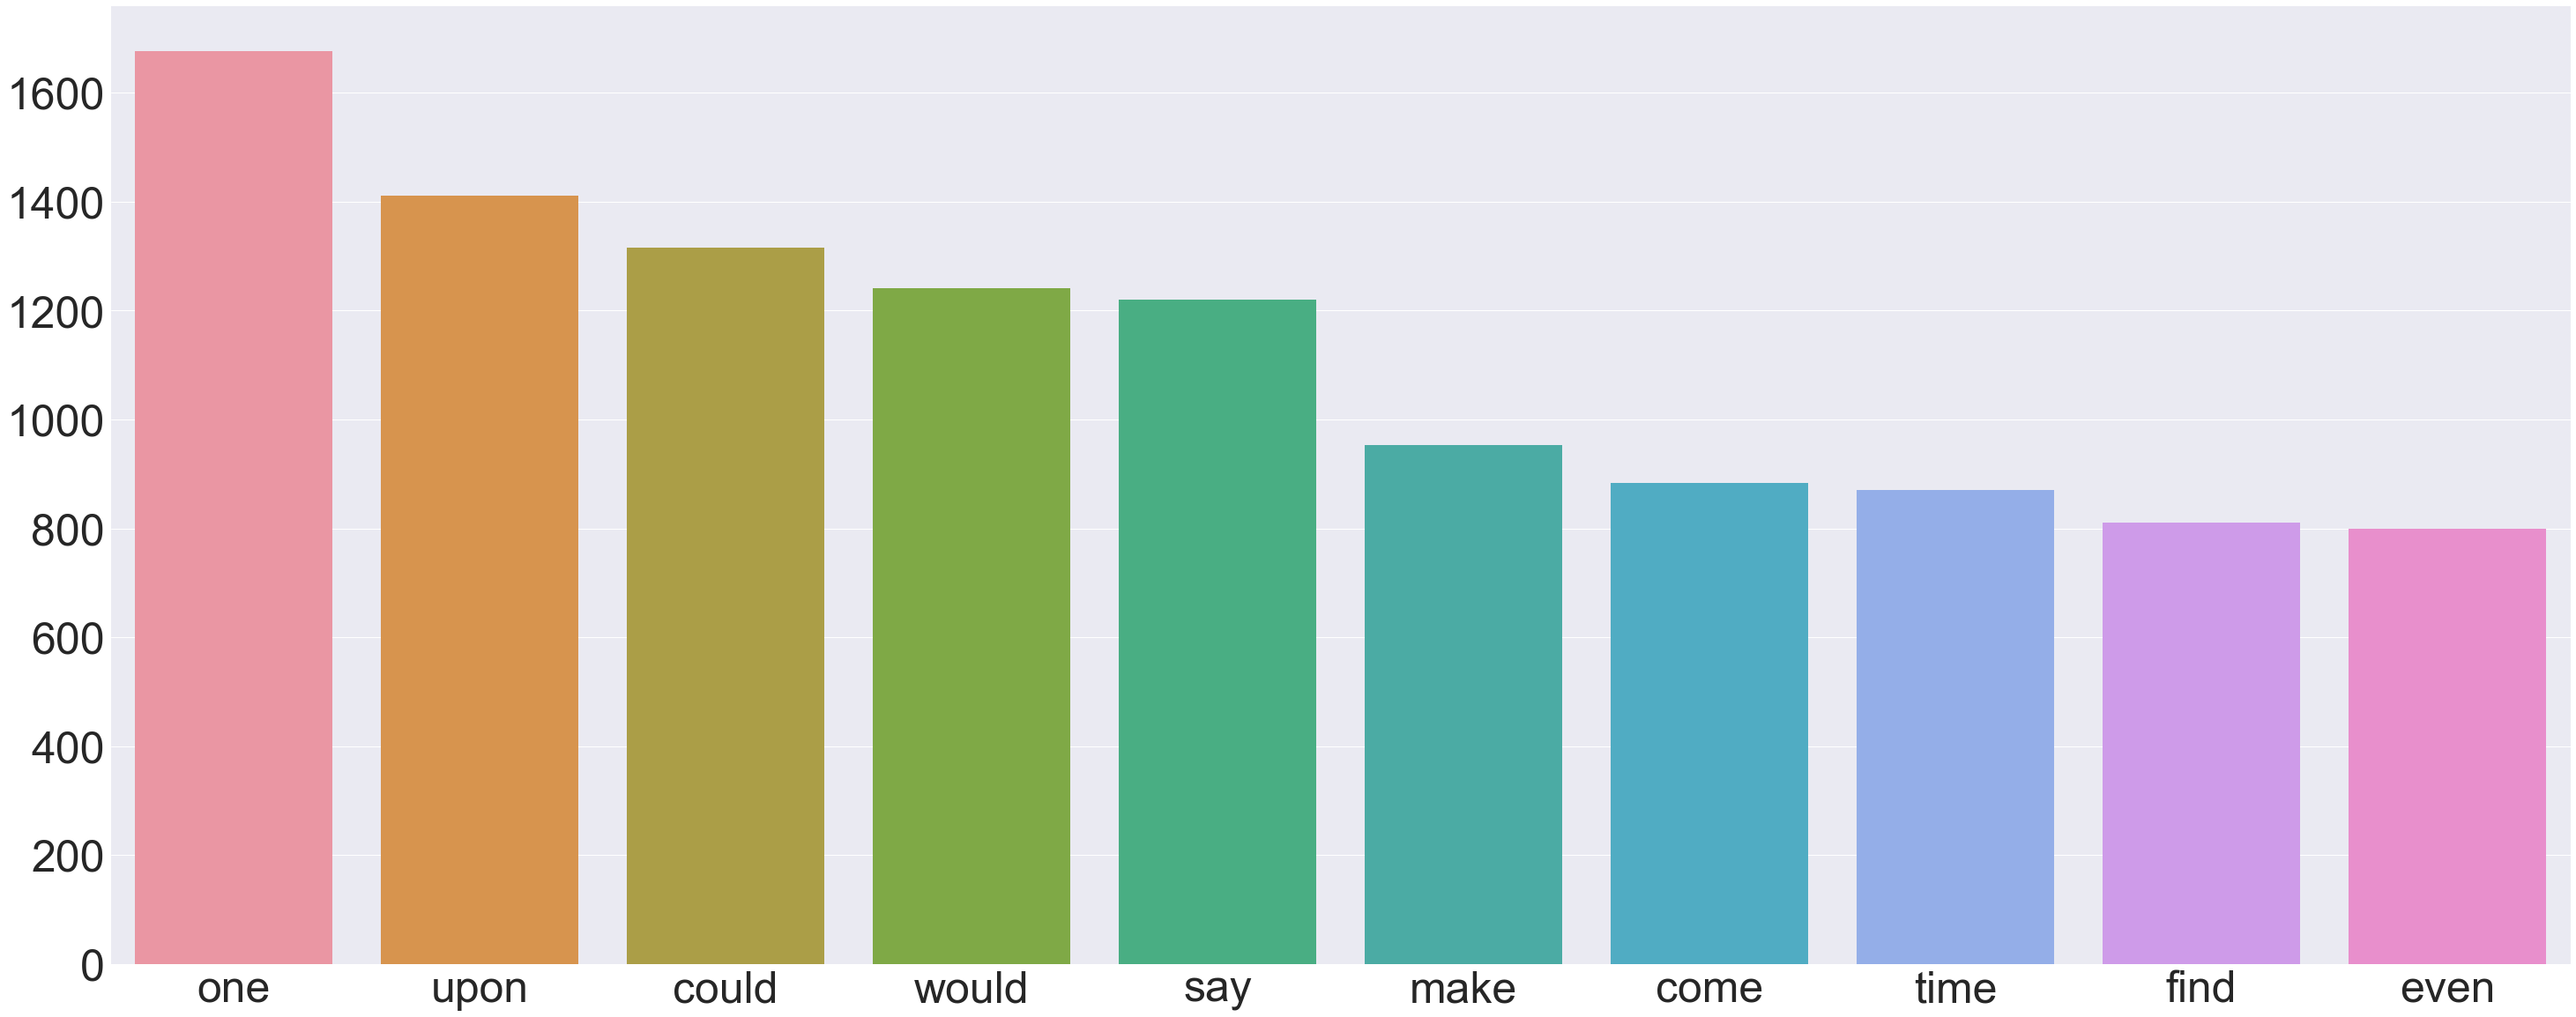

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(50,20)
sns.barplot(x=all_words[0:10].index, y=all_words[0:10])

А най-малко използваните?

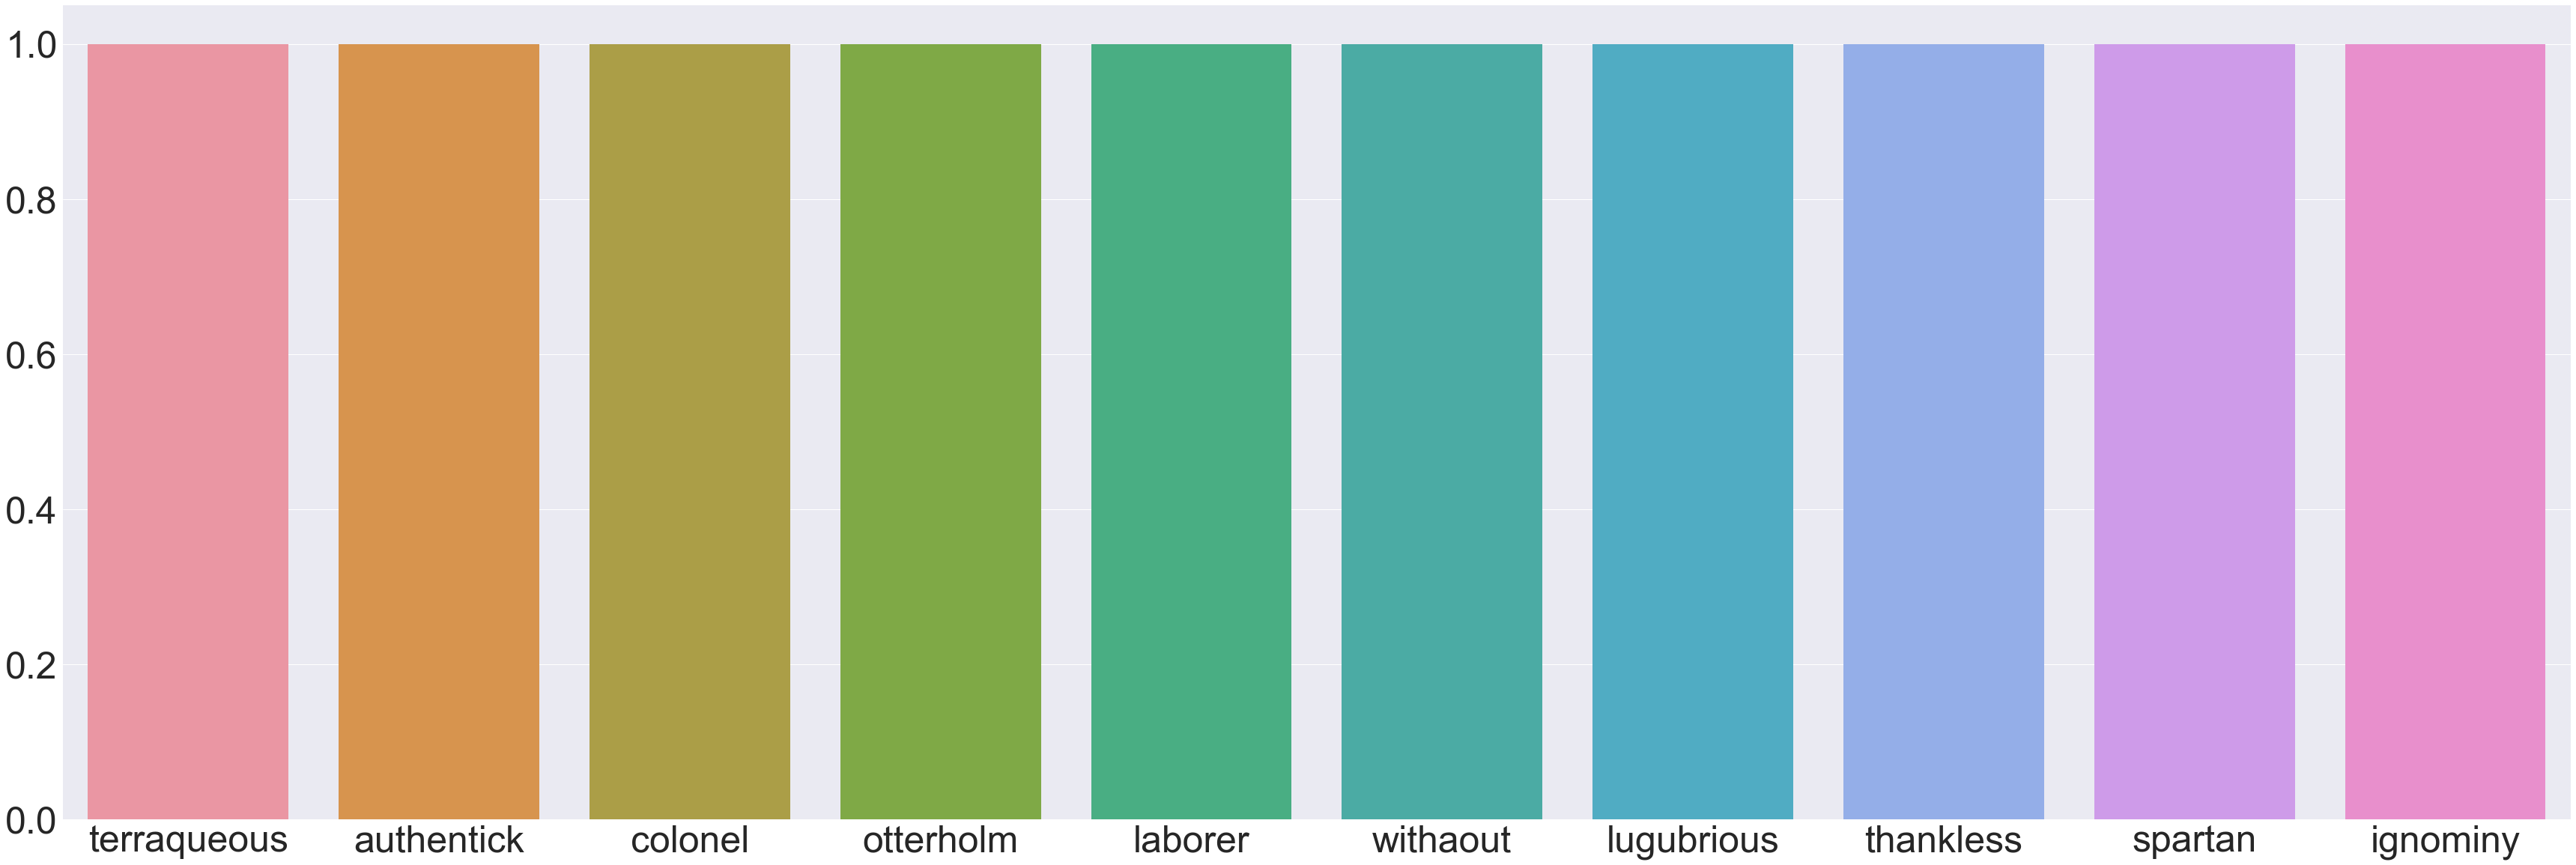

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(60,20)
sns.barplot(x=all_words[-11:-1].index, y=all_words[-11:-1])

<a name='feature'></a>

## Feature engineering

<a name='creative'></a>

### Creative FE

Още първият път, когато видях този data set, силно исках да проверя колко от записите съдържат думата Frankenstein и евентуално да добавя това като feature, защото би бил доста силен feature. Нека най-сетне направя това.

In [15]:
contains_frankenstein = train[train.text.str.contains('frankenstein')].groupby('author')

In [16]:
contains_frankenstein.describe()

text                                 
       count unique                  top freq
author                                       
MWS       19     19  listen frankenstein    1

Едва 19 записа :(

Ще пробвам с друга по-обща дума.

In [17]:
contains_monster = train[train.text.str.contains('monster')].groupby('author')

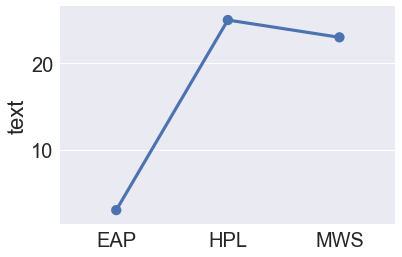

In [18]:
sns.set(font_scale=2)
sns.pointplot(x=contains_monster.count().index.values, y=contains_monster.count().text)

Очаквано предимство за HPL и MWS, но отново твърде малко данни.

Все пак обаче ще направя един трансформатор, който ще образува нови feature-и от тип _contains-word_.

След малко google-ване някои от по-специфичните думи за различните автори:

In [19]:
specific_words = ["frankenstein",  
                  "cthulhu", 
                  "raymond", 
                  "street", 
                  "adrian", 
                  "ligeia", 
                  "arthur", 
                  "azathot", 
                  "nyarlathotep", 
                  "carter", 
                  "herbert", 
                  "victor"]

И сега един много простичък трансформатор, който ще ползвам малко по-късно.

In [20]:
class ContainsWordsFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words):
        self.words = words

    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = pd.DataFrame(data)
        new_features_df = pd.DataFrame();
        for word in self.words:
            column_name = "contains_" + word
            new_features_df[column_name] = data.text.apply(lambda x:(word in x))
        return new_features_df

Така и така си направих функции, които проверяват каква част на речта е дадена дума, затова ще ги използвам, за да добавя още няколко feature-a.

In [21]:
class CountPOSTransformer(BaseEstimator, TransformerMixin):
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = pd.DataFrame(data)
        new_features_df=pd.DataFrame(index=data.index.values)
        new_features_df['nouns'] = data.text.apply(lambda x:sum([1 for w,tag in pos_tag(x.split()) if is_noun(tag)]))
        new_features_df['verbs'] = data.text.apply(lambda x:sum([1 for w,tag in pos_tag(x.split()) if is_verb(tag)]))
        new_features_df['adverbs'] = data.text.apply(lambda x:sum([1 for w,tag in pos_tag(x.split()) if is_adverb(tag)]))
        new_features_df['adjectives'] = data.text.apply(lambda x:sum([1 for w,tag in pos_tag(x.split()) if is_adjective(tag)]))
        new_features_df['fw'] = data.text.apply(lambda x:sum([1 for w,tag in pos_tag(x.split()) if is_foregin(tag)]))
        return new_features_df

In [22]:
POS_counted = CountPOSTransformer().fit_transform(train)

In [23]:
POS_train = pd.concat([train,POS_counted], axis=1)

In [24]:
POS_train.head(10)

,text,author,nouns,verbs,adverbs,adjectives,fw
id,,,,,,,
id26305,process however afford mean ascertain dimensio...,EAP,11,3,2,3,0
id17569,never occur fumble might mere mistake,HPL,0,3,1,1,0
id11008,left hand gold snuff box caper hill cut manner...,EAP,10,3,2,4,0
id27763,lovely spring look windsor terrace sixteen fer...,MWS,13,0,1,5,0
id12958,find nothing else even gold superintendent aba...,HPL,8,2,3,3,0
id22965,youth pass solitude best year spend gentle fem...,MWS,25,3,2,10,0
id09674,astronomer perhaps point take refuge suggestio...,EAP,6,3,2,1,0
id13515,surcingle hung ribands body,EAP,3,1,0,0,0
id19322,knew could say stereotomy without brought thin...,EAP,17,4,8,8,0


In [25]:
sns.set(font_scale=1.5)

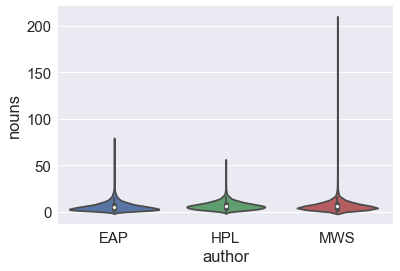

In [26]:
sns.violinplot(x='author', y='nouns', data=POS_train)

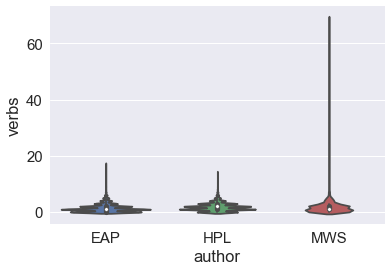

In [27]:
sns.violinplot(x='author', y='verbs', data=POS_train)

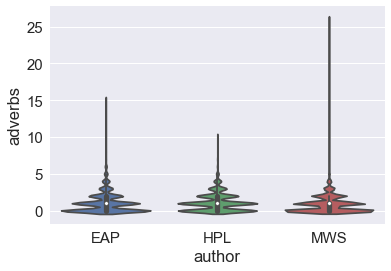

In [28]:
sns.violinplot(x='author', y='adverbs', data=POS_train)

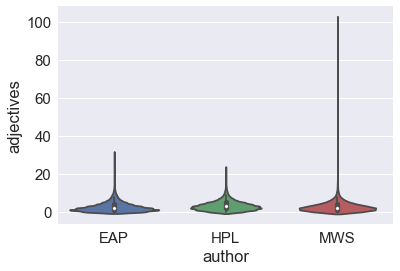

In [29]:
sns.violinplot(x='author', y='adjectives', data=POS_train)

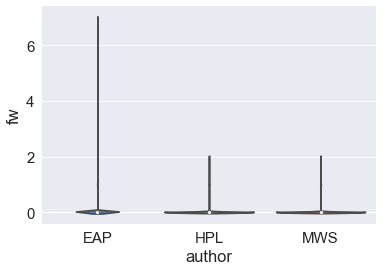

In [30]:
sns.violinplot(x='author', y='fw', data=POS_train)

Сравнително близки показатели, но се забелязват и някои различия. В крайна сметка тези featur-и няма да ги ползвам, защото после правят нещата много бавни, а и не смятам, че ще окажат голямо влияние.

<a name='lda'></a>

### LDA/NMF

[Тази](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730) статия ми помогна да направя долните неща.

Ще ползвам TfidfVectorizer за NMF и CountVectorizer за LDA

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(train.text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = count_vectorizer.fit_transform(train.text)
count_vectorizer_feature_names = count_vectorizer.get_feature_names()

Здраво copy-paste на параметрите.

In [32]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


Нека видим какво представляват откритите topic-и.

In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("NMF TOPICS:")
display_topics(nmf, tfidf_feature_names, no_top_words)
print()
print("LDA TOPICS:")
display_topics(lda, count_vectorizer_feature_names, no_top_words)

NMF TOPICS:
Topic 0:
time make man day thing even yet find go take
Topic 1:
say dupin shall nothing let little much mean man sir
Topic 2:
could nothing distinguish believe help perceive word scarcely understand tell
Topic 3:
one another two old side every singular small thing end
Topic 4:
upon look fell hand head subject sit throw lay character
Topic 5:
would return think hop alone case better death raymond restore
Topic 6:
know well nothing thing whether god world knew tell believe
Topic 7:
come back whence night still sound men last home go
Topic 8:
see let ask ever nobody dark shall glad face fool
Topic 9:
never may speak hear love forget believe world idea suffer

LDA TOPICS:
Topic 0:
every ever young raymond might part spirit good life upon
Topic 1:
say upon much head know nothing open beyond mr make
Topic 2:
hand upon hope cause stone wonder length step escape reach
Topic 3:
yet one fear think speak see never even let say
Topic 4:
house man thus old door great could window work t

Почти безсмислени topic-и по мое мнение, но все пак ще ползвам LDA и NMF и ще видя какви резултати ще постигна с тях.

<a name='model'></a>

## Трениране на модели

Време е за действие.

Два FeatureUnion-a(един, когато ползваме LDA, и един за NMF), които да обединият всички feature-и, които правихме досега.

Те няма да бъдат подлагани на GridSearch, защото GridSearch-a започва да става мнооого бавен. 

In [34]:
lda_topics_pipeline = Pipeline([('vectorizer', CountVectorizer(max_df=0.95, min_df=2)),
                                ('topics',LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.))
                               ])

lda_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',lda_topics_pipeline),
                                  ('vectorizer', CountVectorizer(max_df=0.95, min_df=2))
                                 ])

nmf_topics_pipeline = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2)),
                                ('topics',NMF(n_components=10, alpha=.1, l1_ratio=.5, init='nndsvd'))
                               ])

nmf_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',nmf_topics_pipeline),
                                  ('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2))
                                 ])

Ще пробвам с MultinomialNB и LogisticRegression, защото при Лъчо даваха най-добри резултати :D, а и имат по-малък брой 
хипер-параметри, които да бъдат оптимизирани и това ще направи GS-а една идея по-бърз.

Това съм го изпълнявал само веднъж, защото отне твърде много време.

In [36]:
pipe = Pipeline([('features',lda_feature_union),
                 ('clf',MultinomialNB())
                ])

grid = [
    {
        'clf': [MultinomialNB()],
        'features': [lda_feature_union, nmf_feature_union],
        'clf__alpha':[0.1, 0.3, 0.5, 1, 1,5]
    },
    {
        'clf': [LogisticRegression()],
        'features': [lda_feature_union, nmf_feature_union],
        'clf__C':[0.1, 0.5, 1, 5]
    }
]

search = GridSearchCV(pipe, grid, cv=3, scoring='neg_log_loss')
search.fit(train.text, train.author)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'clf': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), 'clf__alpha': 0.1, 'features': FeatureUnion(n_jobs=1,
       transformer_list=[('contains_word', ContainsWordsFeatureTransformer(words=['frankenstein', 'cthulhu', 'raymond', 'street', 'adrian', 'ligeia', 'arthur', 'azathot', 'nyarlathotep', 'carter', 'herbert', 'victor'])), ('topics', Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='...
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None))],
       transformer_weights=None)}

Best cross-validation score: -0.47


Ще направя още един GS, но само за MultinomialNB.

Пробвах да прекарам данните и през PCA, но в случая имах sparse данни, затова ползвах TruncatedSVD. И крос валидирах с LogisticRegression, защото MultinomialNB не работи с negative input. Резултатие бяха слаби, а отне много време затова махнах тази крос валидация и само я споменавам сега.

In [37]:
pipe = Pipeline([('features',nmf_feature_union),
                 ('clf', MultinomialNB())
                ])

grid = [
    {
        'clf__alpha':[0.005,0.01, 0.05, 0.1, 0.3],
        'features__vectorizer__ngram_range':[(1,1),(1,2),(1,3),(2,3),(1,4)]
    }
]

search = GridSearchCV(pipe, grid, cv=3, scoring='neg_log_loss')
search.fit(train.text, train.author)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'clf__alpha': 0.05, 'features__vectorizer__ngram_range': (1, 2)}

Best cross-validation score: -0.45


Имаме си фаворит.

In [38]:
nmf_topics_pipeline = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2)),
                                ('topics',NMF(n_components=10, alpha=.1, l1_ratio=.5, init='nndsvd'))
                               ])

nmf_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',nmf_topics_pipeline),
                                  ('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2)))
                                 ])

pipe = Pipeline([('features',nmf_feature_union),
                 ('clf', MultinomialNB(alpha=0.05))
                ])

pipe.fit(train.text, train.author)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('contains_word', ContainsWordsFeatureTransformer(words=['frankenstein', 'cthulhu', 'raymond', 'street', 'adrian', 'ligeia', 'arthur', 'azathot', 'nyarlathotep', 'carter', 'herbert', 'victor'])), ('topics', Pipeline(memory=None,
   ...   transformer_weights=None)), ('clf', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

Открадвам фунцкията за чертаене на confusion_matrix-a.

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

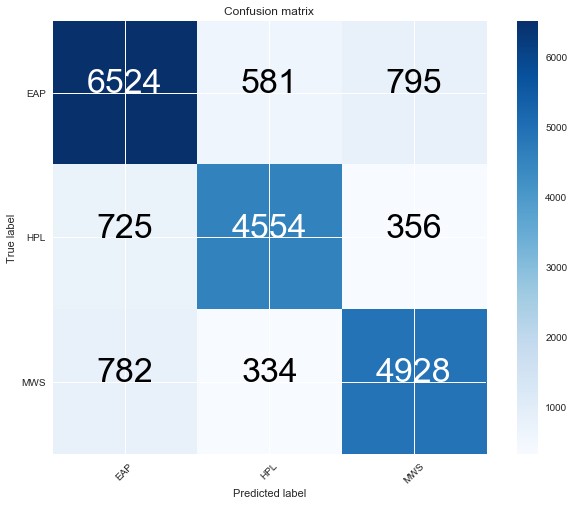

In [40]:
sns.set(font_scale=1)
prediction = cross_val_predict(pipe,train.text, train.author, cv=3)
plot_confusion_matrix(train.author, prediction, classes=pipe.classes_)

Най-проблематичен е класът на EAP. Може би, защото е най-многоброен.

<a name='submit'></a>

## Submission

In [41]:
test = pd.read_csv('data\\test.csv', index_col='id')

In [42]:
test.text = test.text.apply(lambda x:" ".join(tokenizer.tokenize(x.lower().strip()))) 
test.text = test.text.apply(lambda x:" ".join([y for y in x.split() if not y in stop_words]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'n') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'v') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'a') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'s') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'r') for y in x.split()]))

In [43]:
test.head()

,text
id,
id02310,still urge leave ireland inquietude impatience...
id24541,fire want fan could readily fan newspaper gove...
id00134,break frail door find two cleanly pick human s...
id27757,think possibly manage without one actually tum...
id04081,sure limit knowledge may extend


In [44]:
test_predictions = pipe.predict_proba(test.text)

In [45]:
submit_file = pd.DataFrame(test_predictions, columns=pipe.classes_, index=test.index)
submit_file.head(10)

,EAP,HPL,MWS
id,,,
id02310,0.100017,0.037249,0.862735
id24541,0.867839,0.067954,0.064207
id00134,0.499023,0.476717,0.024260
id27757,0.601920,0.396944,0.001136
id04081,0.812976,0.116072,0.070953
id27337,0.557232,0.429588,0.013180
id24265,0.439754,0.459186,0.101061
id25917,0.088148,0.080296,0.831556
id04951,0.979713,0.019855,0.000432


In [46]:
submit_file.to_csv('data\\submission.csv')

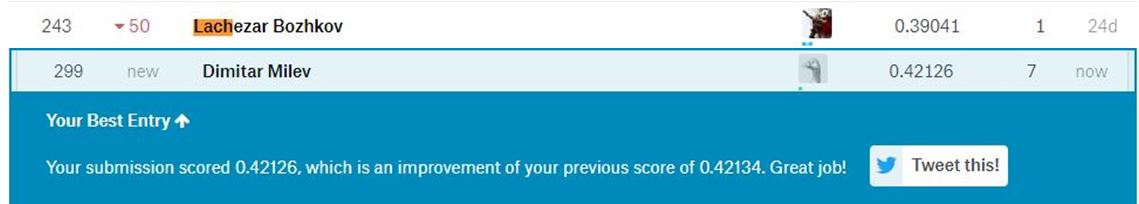

In [47]:
from IPython.display import Image
Image("me_vs_lacho.jpg")

Печално.

<a name='conclusion'></a>

## Заключение

Подходът ми към проблема беше да опитам неща, които Лъчо не направи. Използвах LDA/NMF, добавих нови feature-и, но в крайна сметка моделът ми малко или много наподоби този на Лъчо. Това можеше да се очаква, защото все пак не позлвах кой знае колко различни средства и с този апарат това са максималните резултати. Пробвах и с други модели, които не съм оставил в notebook-a, като например: VotingClassifier; модела базиран само на LDA/NMF feature-ите; модел базиран само на feature измислени от мен, но всеки един от тези се проваляше стабилно. Като цяло съм доволен от това, което постигнах, а и упражних много нови за мен неща.